#GPUs

nvidia-smi --query-compute-apps=pid --format=csv,noheader | xargs -I {} ps -p {} -o pid,cmd --no-headers


kill <PID>
kill -9 <PID>            (forces the kill)

In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import * # added Losses for multiclassifier
from plotting import * #plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : cpu


/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:

import sys
import os

# Ensure the src directory is in your path
src_dir = os.path.abspath("../src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from preprocess_cache import get_preprocessed_dataset
from torch.utils.data import DataLoader

# Load cached/preprocessed dataset
data = get_preprocessed_dataset(cache_path="cached_dataset.pkl")
train_dataset      = data["train_dataset"]
valid_dataset      = data["valid_dataset"]
val_weight_nominal = data["val_weight_nominal"]
X = data["X"]
y = data["y"]
pad_mask           = data["pad_mask"]
event_level        = data["event_level"]
reweighting        = data["reweighting"]
weight_nominal_tensor = data["weight_nominal_tensor"]

train_X            = data["train_X"]
val_X              = data["val_X"]
train_y            = data["train_y"]
val_y              = data["val_y"]
train_weights      = data["train_weights"]
val_weights        = data["val_weights"]
train_mask         = data["train_mask"]
val_mask           = data["val_mask"]
train_event        = data["train_event"]
val_event          = data["val_event"]
train_weight_nominal = data["train_weight_nominal"]
outdir             = data["outdir"]
data_columns           = data["data_columns"]



# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=10,
)

valid_loader = DataLoader(
valid_dataset, 
batch_size=10000, 
shuffle=False,
num_workers = 10,
)



Loading preprocessed data from cache...


In [3]:
print(data_columns)

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

### If Loading checkpoint, skip up to CheckpointCell

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$ #beam axis?
- var 2 : $\phi$ #beam axis? 
- var 3 : mass
- var 4 : area
- var 5 : btag #probability of whether the jet is a btag, assigned by separate algorithm


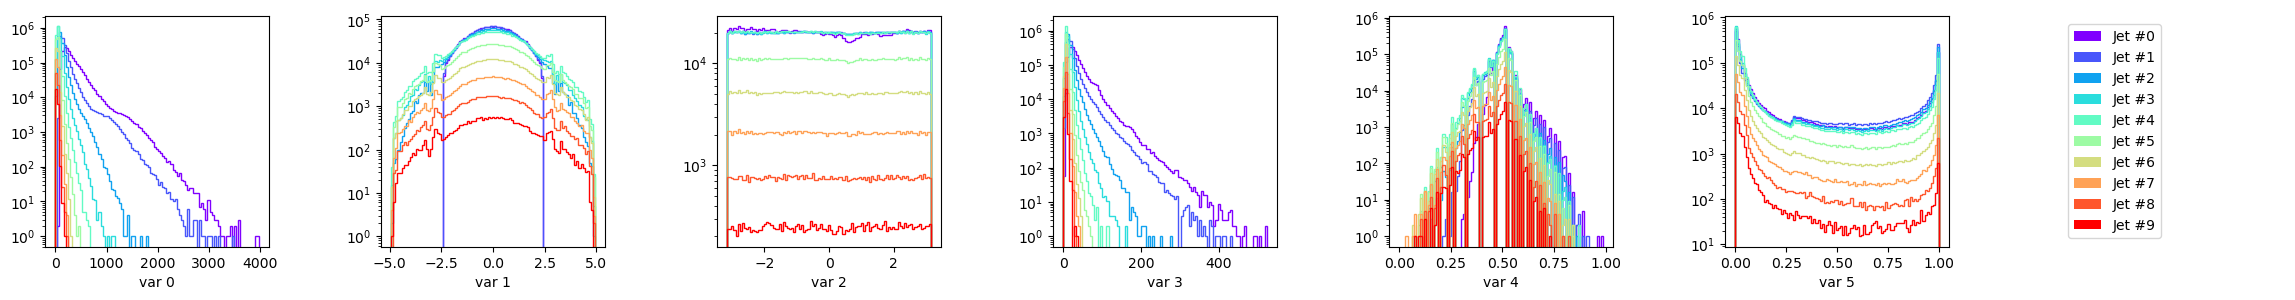

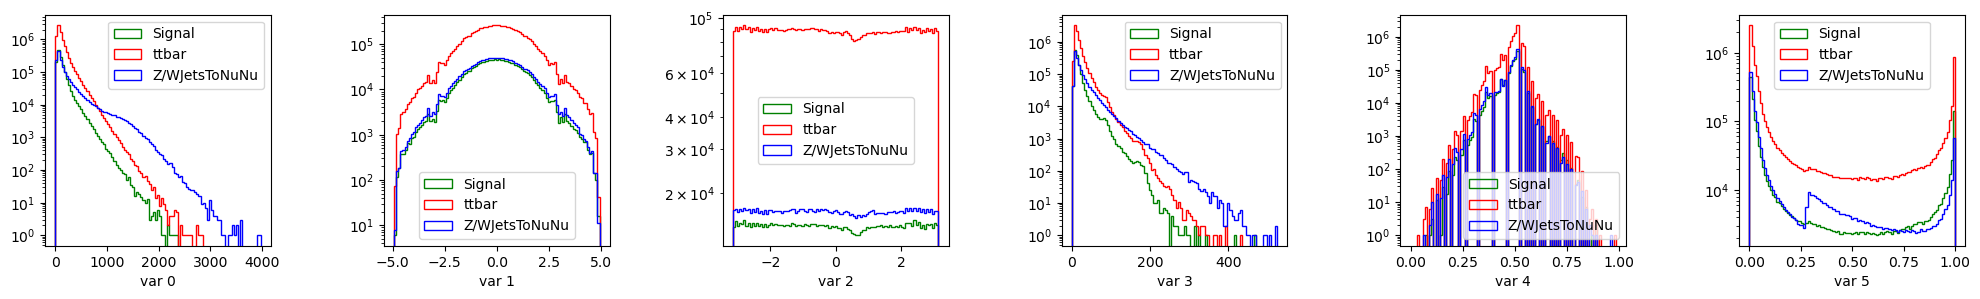

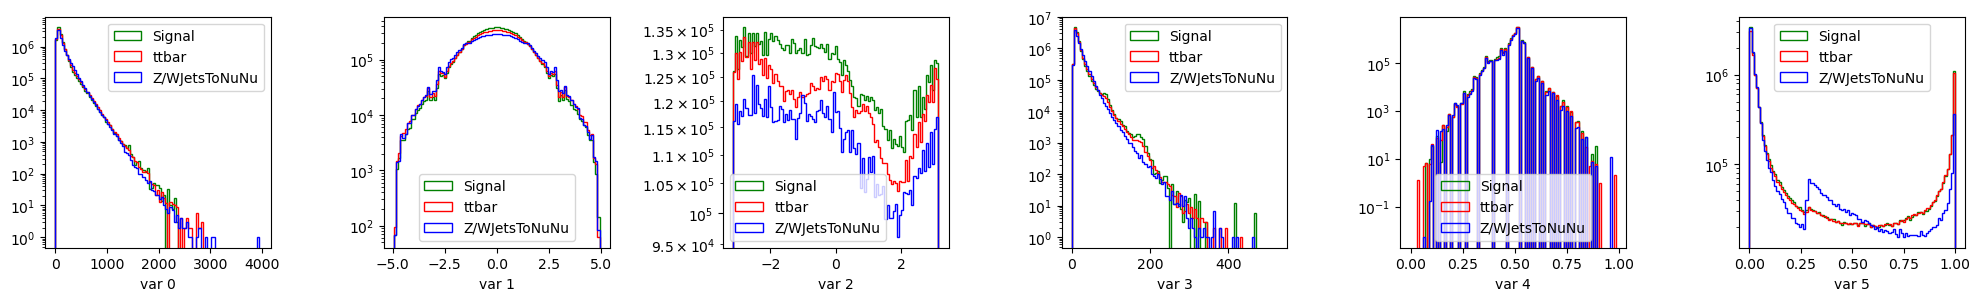

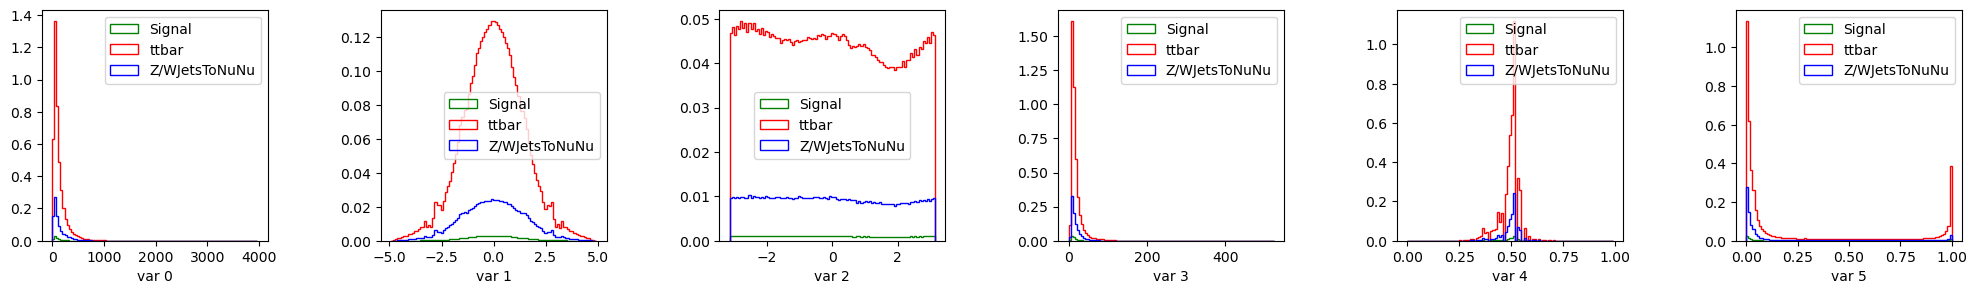

In [4]:
###MULTICLASSIFICATION###

fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=reweighting, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=weight_nominal_tensor, log=False, show=True)


# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [5]:
import torch.nn.functional as F

# Define model #

########
#MULTICLASSIFICATION: CrossEntropyLoss, FocalLoss?
########



#loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss 
# lambda = 0 -> pure BCE

#loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True) # This is CrossEntropyLoss with decorrelation loss
#loss_function = MulticlassDecorrelatedFocalLoss(gamma=0.5, alpha=None, lam=0.1, weighted=True) #gamma = 0 -> pure crossentropy

gamma = 0.52

loss_function = MulticlassFocalLoss(gamma=gamma, alpha=None, weighted=True)

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)


#LAYERS:
#Play around with the number of encoder layers, class layers and dnn layers.

encoder_layers = 5
class_layers = 3
dnn_layers = 3


model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim)
    output_dim = 3,                  # Output dimension (1 : binary classification, >1 : multi classification) - 4 for multiclass
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) changed 4 to 2
    encoder_layers = encoder_layers,              # Number of encoder layers (self attention on jets), increased to 5
    class_layers = class_layers,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn_layers,                  # Number of layers for DNN after the transformer (most of heavy lifting done by trnasformer, dont need >3)
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

Batch dtypes torch.float32 torch.float32 torch.float32 torch.bool torch.float32
outputs torch.Size([1024, 3])
losses tensor(2.6576, grad_fn=<MeanBackward0>)


# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [6]:
##### Parameters #####
epochs = 100 #was 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4,               #reduce the learning rate after 4 (was 10) epochs without improvement
   threshold = 0.,              #threshold for measuring the new optimum
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,               #minimum learning rate
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback_Multiclass(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback_Multiclass(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback_Multiclass(name='ROC'),
        ConfusionMatrixSubCallback_Multiclass(name='CM'),
    ]
)

## Logger ##
##Commented out for now to avoid large comet log files

logger = CometLogger(
    #api_key = os.getenv("COMET_API_KEY"),
    #api_key = "",
    project_name = "MSci-AnalysisObjectTransformer",
    experiment_name = f"3 BG, FL ({gamma}gamma): {lr}lr, {encoder_layers}enc, {class_layers}clas, {dnn_layers}dnn",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    #strategy = "ddp_notebook",  # Use distributed data parallel
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = 1,#[2,3,4], # Number of GPUs. Notebook only supports 1
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        #plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)

trainer.save_checkpoint(f"{outdir}/model.pt")

Training   : Batch size = 1024 => 1561 steps per epoch
Validation : Batch size = 10000 => 40 steps per epoch


CometLogger will be initialized in offline mode
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/model_training/MulticlassTransformer3BG_20250313_124646 exists and is not empty.

  | Name           | Type                | Params | Mode 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level :

### Load Checkpoint Here, else skip

- Run everything from start, skipping trainer cell, then run the below cells.

In [3]:
# # Load the best checkpoint
# checkpoint_path = f"./model_training/AOTransformer_20250217_195245/model.pt" #2BG, ttbar and W/ZJets, ~45epochs, regions [0,6]

# #checkpoint_path = f"./model_training/AOTransformer_20250204_140750/model.pt"
# loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True)

# # First recreate embedding with same configuration
# # Embedding of the jet features into a higher dimension
# embedding = Embedding(
#     input_dim = 6,                  # Input dimension
#     embed_dims = [64],               # Output dimension
#     normalize_input = True,          # Whether to apply batch norm before the embedding
# )


# # Now load the checkpoint
# model = AnalysisObjectTransformer.load_from_checkpoint(
#     checkpoint_path,
#     embedding=embedding,
#     embed_dim=embedding.dim,
#     num_heads=8,
#     output_dim=4,  # Match checkpoint's output dimension
#     expansion_factor=4,
#     encoder_layers=5,
#     class_layers=2,
#     dnn_layers=3,
#     hidden_activation=nn.GELU,
#     output_activation=None,
#     dropout=0.25,
#     loss_function=loss_function,
#     strict=False,
# )

# # Set model to evaluation mode
# model.eval()




In [4]:
# import torch

# checkpoint_path = "./model_training/AOTransformer_20250204_140750/model.pt"
# loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True)

# # Recreate embedding with the original training input dimension (6)
# embedding = Embedding(
#     input_dim=6,           # Original training input dimension
#     embed_dims=[64],
#     normalize_input=True,
# )

# # Manually load the checkpoint state dictionary
# checkpoint = torch.load(checkpoint_path, map_location="cpu")
# state_dict = checkpoint["state_dict"]

# # Remove the mismatched final layer parameters so new layer is used.
# for key in ["dnn.6.weight", "dnn.6.bias"]:
#     if key in state_dict:
#         print(f"Removing {key} from checkpoint state_dict")
#         del state_dict[key]

# # Create a new instance of your model with the desired output_dim (4)
# model = AnalysisObjectTransformer(
#     embedding=embedding,
#     embed_dim=embedding.dim,
#     num_heads=8,
#     output_dim=4,         # New output configuration
#     expansion_factor=4,
#     encoder_layers=5,
#     class_layers=2,
#     dnn_layers=3,
#     hidden_activation=nn.GELU,
#     output_activation=None,
#     dropout=0.25,
#     loss_function=loss_function,
# )

# # Load the modified state_dict (missing keys will be ignored)
# load_msg = model.load_state_dict(state_dict, strict=False)
# print("Load message:", load_msg)

# model.eval()

### continue

In [ ]:
# ## Testing model performance on validation set ##




## Testing model performance on validation set ##
trainer = L.Trainer(accelerator=accelerator, devices=1)

preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)


# Get data
inputs, labels, weights, mask, event = valid_dataset.tensors

probs = torch.softmax(preds, dim=1)  # Convert to probabilities

# Get predicted classes
pred_classes = torch.argmax(probs, dim=1)

# Calculate accuracy per class
for i in range(3):
    mask_i = labels == i
    acc_i = (pred_classes[mask_i] == labels[mask_i]).float().mean()
    print(f"Class {i} accuracy: {acc_i:.3f}")

# Overall accuracy
acc = (pred_classes == labels).float().mean()
print(f"\nOverall accuracy: {acc:.3f}")

print(f"\nPredictions shape: {preds.shape}")  # Should show 3 classes in second dimension

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NameError: name 'model' is not defined

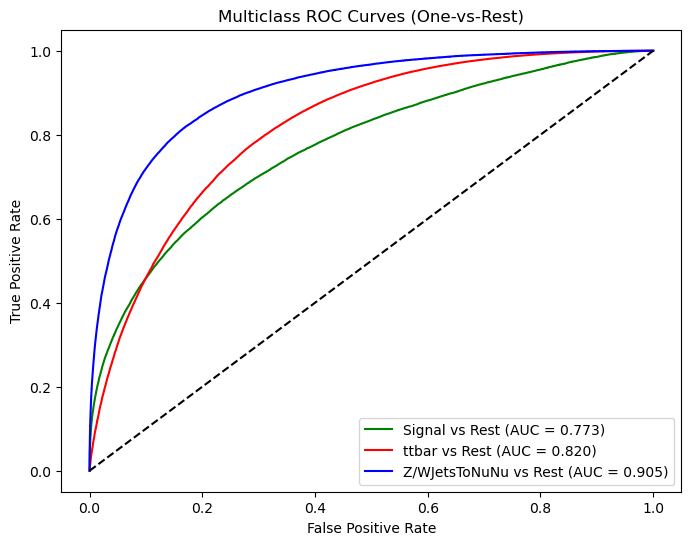

In [ ]:
# Plot multiclass ROC curves
fig = plot_multiclass_roc(labels, probs, outdir=outdir, show=True)


# Plotting Significance (Z-Score) 


No systematic:
Max significance: 6.06
At threshold: 0.940
S: 25.2
B: 17.3

5% systematic:
Max significance: 5.95
At threshold: 0.970
S: 9.9
B: 2.8

10% systematic:
Max significance: 5.89
At threshold: 0.970
S: 9.9
B: 2.8


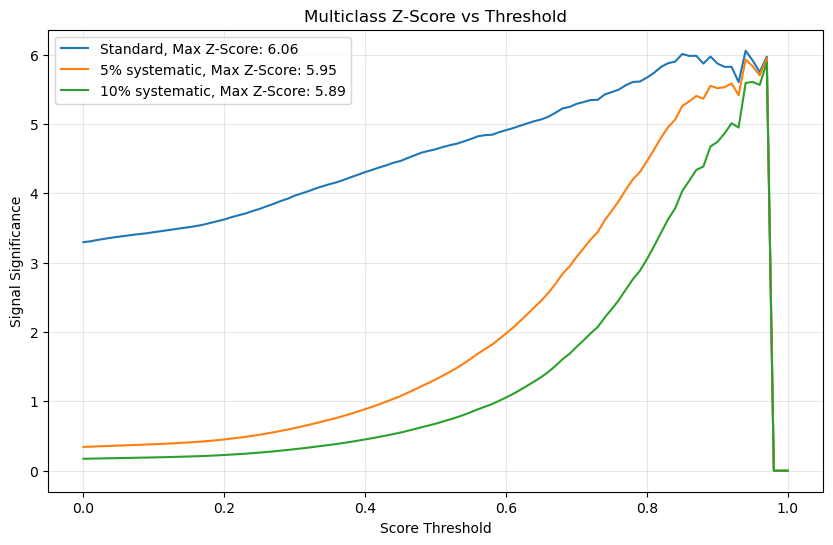

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0].flatten()

# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()

# Weigh events (example: multiply nominal weights by 2e5 for convenience)
#event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
event_weights_np = np.array((val_weight_nominal *200000).flatten())

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S >= 10 and B >= 10:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

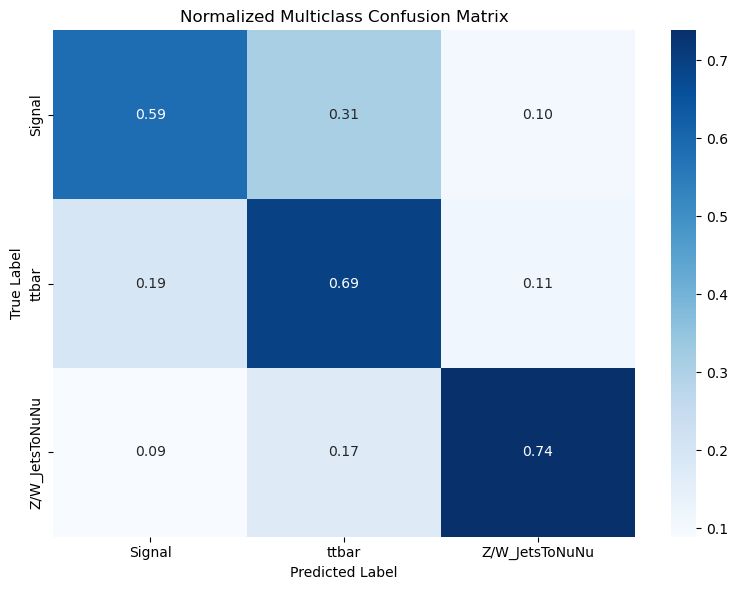

In [ ]:
# # # filepath: /home/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/training_multiclassification.ipynb

# import torch
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # After training, switch model to eval mode
# model.eval()

# all_preds = []
# all_labels = []

# # Gather predictions and labels from validation set
# with torch.no_grad():
#     for inputs, labels, weights, mask, event in valid_loader:
#         outputs = model(inputs, padding_mask=mask)
#         preds = torch.argmax(outputs, dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Define class labels
# class_names = ['Signal', 'ttbar', 'Z/W_JetsToNuNu']

# # Generate normalized confusion matrix
# cf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2], normalize='true')

# plt.figure(figsize=(8,6))  # Increased figure size for 4x4 matrix
# sns.heatmap(cf_matrix, 
#             annot=True, 
#             cmap='Blues', 
#             fmt='.2f',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Normalized Multiclass Confusion Matrix')
# plt.tight_layout()
# plt.show()

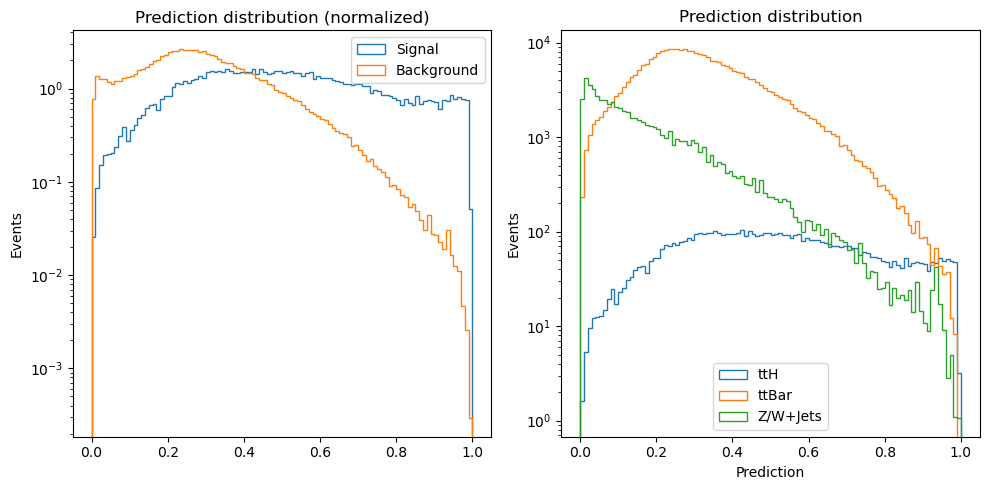

In [ ]:
# import numpy as np 
# import matplotlib.pyplot as plt

# # Get the validation tensors from valid_dataset:
# # (Assumes valid_dataset was created via train_test_split)
# val_inputs, val_labels, val_weights, val_mask, val_events = valid_dataset.tensors

# # Convert validation labels and weights to numpy
# labels_np = val_labels.detach().cpu().numpy().flatten()              # Now shape should match predictions
# weights_np = val_weight_nominal.detach().cpu().numpy().flatten()       # Adjust if needed, should match labels_np

# # Convert predictions (probs) to numpy (they come from trainer.predict on valid_loader)
# probs_np = probs.detach().cpu().numpy()  # shape (N, num_classes)

# # Extract only the ttH column (class 0)
# ttH_probs = probs_np[:, 0]

# # Create binary labels: 1 for signal (ttH, when original label==0), 0 for background (label>0)
# binary_labels = np.where(labels_np == 0, 1, 0)

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

# # ---------------------------
# # First plot: Binary classification (normalized)
# axes[0].hist(ttH_probs[binary_labels == 1], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 1],
#              histtype='step', label='Signal', density=True)
# axes[0].hist(ttH_probs[binary_labels == 0], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 0],
#              histtype='step', label='Background', density=True)
# axes[0].legend()
# axes[0].set_ylabel('Events')
# axes[0].set_yscale('log')
# axes[0].set_title('Prediction distribution (normalized)')

# # ---------------------------
# # Second plot: Multi-class (segmented by true labels using ttH probabilities)
# axes[1].hist(ttH_probs[labels_np == 0], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 0],
#              histtype='step', label='ttH')
# axes[1].hist(ttH_probs[labels_np == 1], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 1],
#              histtype='step', label='ttBar')
# axes[1].hist(ttH_probs[labels_np == 2], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 2],
#              histtype='step', label='Z/W+Jets')
# axes[1].legend(loc='lower center')
# axes[1].set_xlabel('Prediction')
# axes[1].set_ylabel('Events')
# axes[1].set_title('Prediction distribution')
# axes[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

In [16]:
# trainer.save_checkpoint(f"{outdir}/model.pt")
# print("Checkpoints are being saved in:", outdir)

### dHH Plots

In [18]:
# Example: compute probabilities on validation set
val_probs = model(val_X)          # or however you obtained probabilities for validation
probs_np = val_probs.detach().cpu().numpy()
ttH_probs = probs_np[:, 0]
background_probs = probs_np[:, 1] + probs_np[:, 2]
epsilon = 1e-10
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Now extract validation labels which should match the number of predictions
labels = val_y.detach().cpu().numpy()

print("d_hh shape:", d_hh.shape)
print("labels shape:", labels.shape)

d_hh shape: (399567,)
labels shape: (399567,)


/tmp/ipykernel_1807425/4217421838.py:7: RuntimeWarning: invalid value encountered in log
  d_hh = np.log(ttH_probs / (background_probs + epsilon))


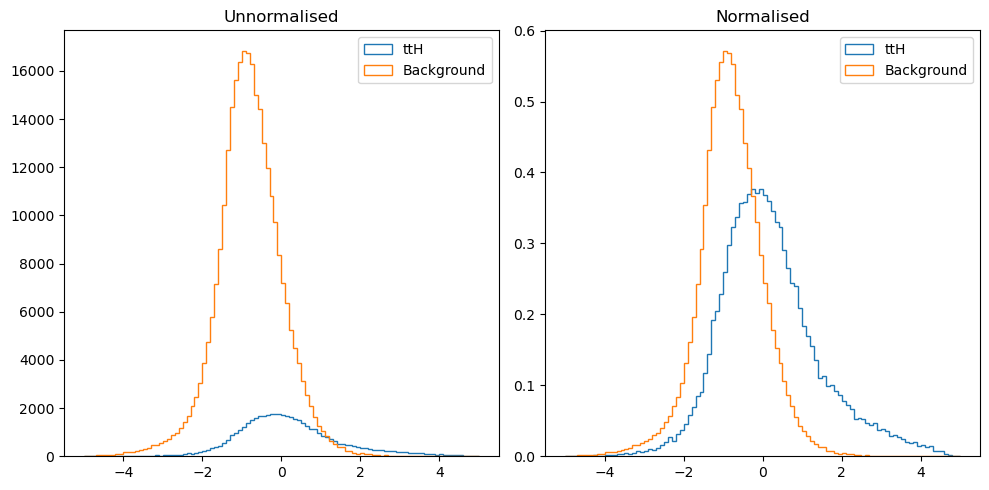

<Figure size 640x480 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Compute d_hh from probabilities (with 2 backgrounds)
# Assuming probs is the tensor of model prediction probabilities (output of softmax)
probs_np = probs.detach().cpu().numpy()  # shape (N, 3)
ttH_probs = probs_np[:, 0]              # Signal probability at index 0
background_probs = probs_np[:, 1] + probs_np[:, 2]  # Sum of the two background probabilities
epsilon = 1e-10  # Avoid division by zero
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Assume labels_flat (numpy array) exists with 0 for ttH and 1 for background
# Plot two subplots: one unnormalised and one normalised

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

axes[0].hist(d_hh[labels == 0], bins=100, range=(-5,5), histtype='step', label='ttH', density=False)
axes[0].hist(d_hh[labels == 1], bins=100, range=(-5,5), histtype='step', label='Background', density=False)
axes[0].legend()
axes[0].set_title('Unnormalised')

axes[1].hist(d_hh[labels == 0], bins=100, range=(-5,5), histtype='step', label='ttH', density=True)
axes[1].hist(d_hh[labels == 1], bins=100, range=(-5,5), histtype='step', label='Background', density=True)
axes[1].legend()
axes[1].set_title('Normalised')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

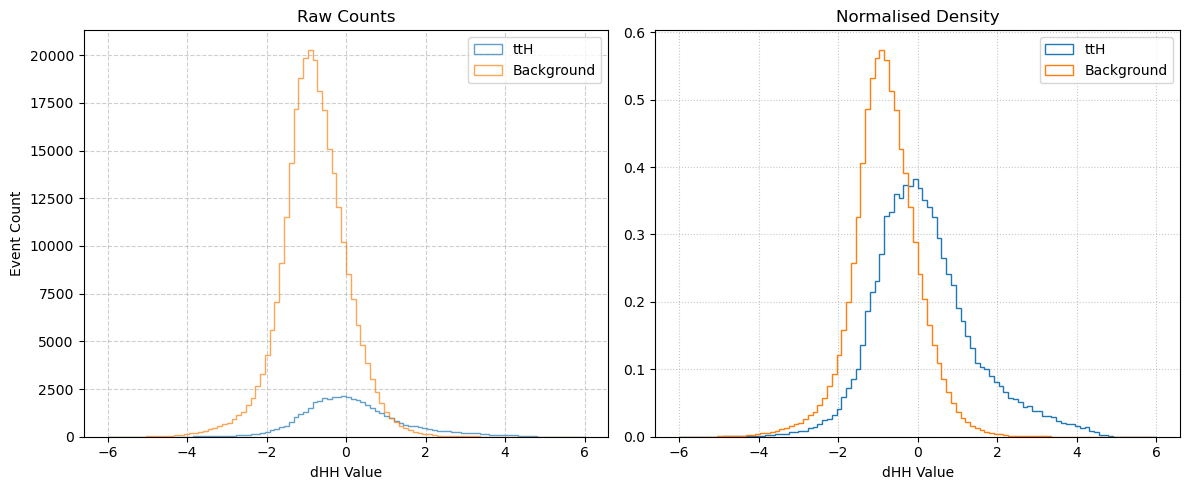

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Compute d_hh from probabilities (with 2 backgrounds)
probs_np = probs.detach().cpu().numpy()  # shape (N, 3)
ttH_probs = probs_np[:, 0]               # Signal probability at index 0
background_probs = probs_np[:, 1] + probs_np[:, 2]  # Sum of two background probabilities
epsilon = 1e-10
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Use labels derived from validation set
labels = val_y.detach().cpu().numpy()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True)

# Unnormalised - using filled histograms and fewer bins:
ax1.hist(d_hh[labels == 0], bins=100, range=(-6, 6), alpha=0.7, label='ttH', histtype='step')
ax1.hist(d_hh[labels == 1], bins=100, range=(-6, 6), alpha=0.7, label='Background', histtype='step')
ax1.set_title("Raw Counts")
ax1.set_xlabel("dHH Value")
ax1.set_ylabel("Event Count")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.6)

# Normalised - using step histograms with thicker lines:
ax2.hist(d_hh[labels == 0], bins=100, range=(-6, 6), density=True, histtype='step', label='ttH')
ax2.hist(d_hh[labels == 1], bins=100, range=(-6, 6), density=True, histtype='step', label='Background')
ax2.set_title("Normalised Density")
ax2.set_xlabel("dHH Value")
ax2.legend()
ax2.grid(linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

In [21]:
print("d_hh shape:", d_hh.shape)
print("labels shape:", labels.shape)  # or labels_flat.shape if using that variable

d_hh shape: (399567,)
labels shape: (399567,)



No systematic:
Max significance: 6.26 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8

5% systematic:
Max significance: 6.23 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8

10% systematic:
Max significance: 6.15 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8


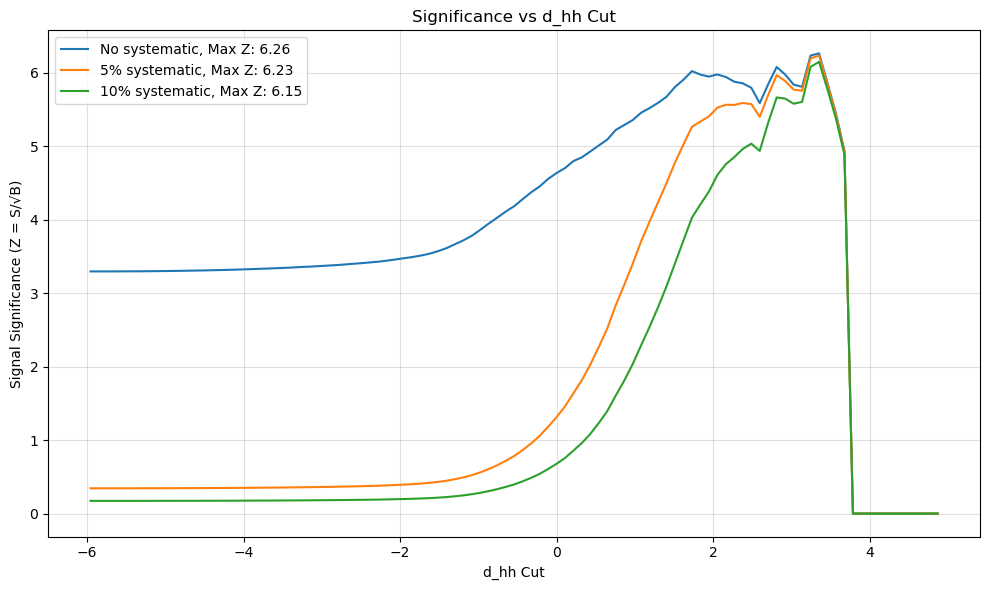

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# (Assuming d_hh was computed already from your probabilities)
# d_hh = np.log(ttH_probs / (background_probs + epsilon))
# And assume ground truth and event weights are available:
truth = labels.flatten()  # ground truth: 0 = signal, 1 = background
event_weights_np = (val_weight_nominal * 200000).detach().cpu().numpy().flatten()

# Prepare d_hh thresholds (cut values) spanning the observed range
thresh_points = np.linspace(np.min(d_hh), np.max(d_hh), 101)

significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Treat events with d_hh greater than the cut as "signal-like"
    signal_mask = (d_hh > cut) & (truth == 0)
    bkg_mask = (d_hh > cut) & (truth != 0)
    
    # Weighted signal and background
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    # Only compute significance if both S and B are non-negligible
    if S > 2 and B > 2:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance and corresponding threshold for each systematic scenario
significance_0 = np.array(significance_0)
significance_5 = np.array(significance_5)
significance_10 = np.array(significance_10)

max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print out details at the optimal thresholds
for thresh_val, sig, label_tag in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    s_mask = (d_hh > thresh_val) & (truth == 0)
    b_mask = (d_hh > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[s_mask])
    B = np.sum(event_weights_np[b_mask])
    
    print(f"\n{label_tag}:")
    print(f"Max significance: {sig:.2f} at d_hh threshold: {thresh_val:.3f}")
    print(f"Signal (S): {S:.1f}")
    print(f"Background (B): {B:.1f}")

# Plot significance vs. d_hh cut
plt.figure(figsize=(10, 6))
plt.plot(thresh_points, significance_0, label=f'No systematic, Max Z: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z: {max_10:.2f}')
plt.xlabel('d_hh Cut')
plt.ylabel('Signal Significance (Z = S/√B)')
plt.title('Significance vs d_hh Cut')
plt.grid(alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()